In [2]:
#!/usr/bin/env python
# coding: utf-8
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
import torchvision
from sklearn.metrics import classification_report


## Model

In [3]:
###############################
###    Load data            ###
###############################

data_list = []
target_list = []

import glob
for fp in glob.glob("/home/ida/tcr-pmhc/data/train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    
    data_list.append(data)
    target_list.append(targets)

In [6]:
X_train = np.concatenate(data_list[ :-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_val = np.concatenate(data_list[-1: ])
y_val = np.concatenate(target_list[-1: ])
nsamples, nx, ny = X_val.shape
print("val set shape:", nsamples,nx,ny)

p_pos_train = len(y_train[y_train == 1])/len(y_train)*100
print("Percent positive samples in train:", p_pos_train)

p_pos_val = len(y_val[y_val == 1])/len(y_val)*100
print("Percent positive samples in val:", p_pos_val)
import sys
from sklearn.preprocessing import normalize
# make the data set into a dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    #X_array = np.transpose(X_train[i][:,:])
    #normalized_X_array = normalize(X_array, axis=1, norm='l1')
    #y_value = y_train[i]
    #train_ds.append([normalized_X_array, y_value])
    train_ds.append([np.transpose(X_train[i][:,:]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    #X_array = np.transpose(X_val[i][:,:])
    #normalized_X_array = normalize(X_array, axis=1, norm='l1')
    #y_value = y_val[i]
    #val_ds.append([normalized_X_array, y_value])
    val_ds.append([np.transpose(X_val[i][:,:]), y_val[i]])

bat_size = 128
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)


# Set device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("Using device (CPU/GPU):", device)
device = torch.device("cpu")


Training set shape: 4538 420 54
val set shape: 1168 420 54
Percent positive samples in train: 24.9669457910974
Percent positive samples in val: 25.0

NOTE:
Setting batch-size to 128


In [5]:
X_array.shape

(54, 420)

In [78]:
################################ TRYING CNN LSTM HYBRID MODELS
###############################
###    Define network       ###
###############################

print("Initializing network")

# Hyperparameters
input_size = 420
num_classes = 1
learning_rate = 0.001 #0.0001
class Net(nn.Module):
    def __init__(self,  num_classes):
        super(Net, self).__init__()
        self.bn0 = nn.BatchNorm1d(54)    
        self.conv1 = nn.Conv1d(in_channels=54, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(100)
        
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm1d(100)
        
        ### try LSTM here

        self.rnn = nn.LSTM(input_size=100,hidden_size=26,num_layers=3, batch_first=True, bidirectional = True) # increase hidden size
        #self.rnn = nn.GRU(input_size=100,hidden_size=26,num_layers=4, dropout=0.1, batch_first=True)
        self.drop = nn.Dropout(p = 0.1)
        ####################################

        self.fc1 = nn.Linear(26*2, num_classes)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.bn0(x)      ### edited after 4:30 PM   
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = x.transpose_(2, 1)
       
        #### lstm
        #x = x.transpose(1, 2).transpose(0, 1)
        #x, state = self.rnn(x)
        #print('size before rnn', x.size())
        
        x, (h, c) = self.rnn(x)
        cat = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1) #x or h
        cat = self.drop(cat)
        #cat = torch.cat((x[:, -1, :50], x[:, 0, 50:]), dim=1)
        #x, h = self.rnn(x)
        #x = x.transpose(0, 1).transpose(1, 2)
        ###
        #print(len(x))
        #x = x.reshape(x.size(0), -1) # burde ikke være nødvendigt
        #x = cat.view(cat.size(0), -1)
        x = torch.sigmoid(self.fc1(cat))
        #x = self.softmax(self.fc1(cat))
        return x
    
# Initialize network
net = Net(num_classes=num_classes).to(device)

## unbalanced loss
#unbal_weight = torch.tensor([1,0.333]).to(device)

# Loss and optimizer
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                       weight_decay=0.0005,
                       amsgrad=True,
                       )
#optim.SGD(net.parameters(), lr=learning_rate)

Initializing network


In [79]:
#####weighted loss
def weighted_binary_cross_entropy(output, target, weights=None):
    if weights is not None:
        assert len(weights) == 2
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)
    return torch.neg(torch.mean(loss))

In [80]:
uniq= np.unique(y_train,return_counts=True)
pos_weight = torch.FloatTensor([np.max(uniq[1])/np.min(uniq[1])])
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(np.max(uniq[1]))
print(np.min(uniq[1]))
criterion = nn.BCEWithLogitsLoss()

3405
1133


In [81]:
###############################
###         TRAIN           ###
###############################

print("Training")

num_epochs = 30

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
losses = []
val_losses = []

val_acc_test = []

no_epoch_improve = 0
min_val_loss = np.Inf

for epoch in range(num_epochs):
    cur_loss = 0
    val_loss = 0
    
    net.train()
    train_preds, train_targs, train_probs = [], [], []
    for batch_idx, (data, target) in enumerate(train_ldr):
        X_batch =  data.float().detach().requires_grad_(True)
        target_batch = torch.tensor(np.array(target), dtype = torch.float).unsqueeze(1)
        
        optimizer.zero_grad()
        output = net(X_batch)
        
        #batch_loss = weighted_binary_cross_entropy(output, target_batch, [0.75,0.25])
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #preds = np.round(output.detach().cpu())
        #train_targs += list(np.array(target_batch.cpu()))
        #train_preds += list(preds.data.numpy().flatten())        
        prob = torch.sigmoid(output.detach())
        preds = np.round(prob)
        preds = np.round(output.detach())
        train_probs += list(prob.data.numpy())
        train_targs += list(np.array(target_batch))
        train_preds += list(preds.data.numpy())
        cur_loss += batch_loss.detach()


    losses.append(cur_loss / len(train_ldr.dataset))        

    net.eval()
    ### Evaluate validation
    val_preds, val_targs, val_probs = [], [], []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_ldr): ###
            x_batch_val = data.float().detach()
            y_batch_val = target.float().detach().unsqueeze(1)
            
            output = net(x_batch_val)

            #val_batch_loss = weighted_binary_cross_entropy(output, y_batch_val, [0.75,0.25])
            val_batch_loss = criterion(output, y_batch_val)

            prob = torch.sigmoid(output.detach())
            preds = np.round(prob)
            preds = np.round(output.detach())
            val_probs += list(prob.data.numpy())
            val_preds += list(preds.data.numpy()) 
            val_targs += list(np.array(y_batch_val))
            val_loss += val_batch_loss.detach()
            
        val_losses.append(val_loss / len(val_ldr.dataset))
        print("\nEpoch:", epoch+1)
        
        train_acc_cur = accuracy_score(train_targs, train_preds)  
        valid_acc_cur = accuracy_score(val_targs, val_preds) 

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)
        
        from sklearn.metrics import matthews_corrcoef
        print("Training loss:", losses[-1].item(), "Validation loss:", val_losses[-1].item(), end = "\n")
        print("MCC Train:", matthews_corrcoef(train_targs, train_preds), "MCC val:", matthews_corrcoef(val_targs, val_preds))
        print("Confusion train:")
        print(confusion_matrix(train_targs, train_preds))
        print("Confusion validation:")
        print(confusion_matrix(val_targs, val_preds))
        ##save model at every epoch
        #torch.save(net.state_dict(), os.path.join(model_dir, 'model-epoch-{}.pt'.format(epoch)))
        #print('Models saved at epoch', epoch+1)

    if (val_loss / len(X_val)).item() < min_val_loss:
        no_epoch_improve = 0
        min_val_loss = (val_loss / len(X_val))
        # save model params
    else:
        no_epoch_improve +=1
    if no_epoch_improve == 4:
        print("Early stopping")
        break

Training

Epoch: 1
Training loss: 0.005906739737838507 Validation loss: 0.005958352237939835
MCC Train: 0.003829069818245066 MCC val: 0.0
Confusion train:
[[3302  103]
 [1097   36]]
Confusion validation:
[[876   0]
 [292   0]]


/home/ida/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Epoch: 2
Training loss: 0.00551104499027133 Validation loss: 0.005946715362370014
MCC Train: 0.0 MCC val: 0.0
Confusion train:
[[3405    0]
 [1133    0]]
Confusion validation:
[[876   0]
 [292   0]]

Epoch: 3
Training loss: 0.00551012484356761 Validation loss: 0.005945144221186638
MCC Train: 0.0 MCC val: 0.0
Confusion train:
[[3405    0]
 [1133    0]]
Confusion validation:
[[876   0]
 [292   0]]

Epoch: 4
Training loss: 0.00550642516463995 Validation loss: 0.00594269810244441
MCC Train: 0.0 MCC val: 0.0
Confusion train:
[[3405    0]
 [1133    0]]
Confusion validation:
[[876   0]
 [292   0]]

Epoch: 5
Training loss: 0.005502468440681696 Validation loss: 0.0059575168415904045
MCC Train: 0.0 MCC val: 0.0
Confusion train:
[[3405    0]
 [1133    0]]
Confusion validation:
[[876   0]
 [292   0]]

Epoch: 6
Training loss: 0.005500000901520252 Validation loss: 0.005926655605435371
MCC Train: 0.038037833272636816 MCC val: 0.14383899044561524
Confusion train:
[[3401    4]
 [1127    6]]
Confusion 

## MH

Train accuracy:
[0.7355663287791979, 0.750330542089026, 0.750330542089026, 0.750330542089026, 0.750330542089026, 0.750771264874394, 0.7767739092111062, 0.7873512560599383, 0.8122520934332305, 0.8292199206698986, 0.8298810048479507, 0.8523578669017188, 0.8490524460114588, 0.8294402820625827, 0.8012340237990304, 0.7822829440282063]
Validation accuracy:
[0.75, 0.75, 0.75, 0.75, 0.75, 0.7568493150684932, 0.7731164383561644, 0.8022260273972602, 0.7970890410958904, 0.8202054794520548, 0.8236301369863014, 0.8595890410958904, 0.8236301369863014, 0.8279109589041096, 0.7602739726027398, 0.800513698630137]


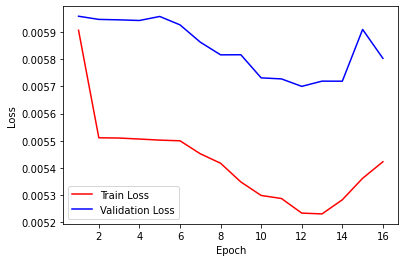

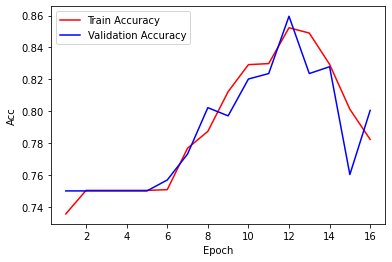

In [82]:
###############################
###        PERFORMANCE      ###
###############################

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, losses, 'r', epoch, val_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Acc')

print("Train accuracy:", train_acc, sep = "\n")
print("Validation accuracy:", valid_acc, sep = "\n")


In [62]:
#### performance
from sklearn.metrics import matthews_corrcoef
print("MCC Train:", matthews_corrcoef(train_targs, train_preds))
print("MCC Test:", matthews_corrcoef(val_targs, val_preds))

print("Confusion matrix train:", confusion_matrix(train_targs, train_preds), sep = "\n")
print("Confusion matrix test:", confusion_matrix(val_targs, val_preds), sep = "\n")



MCC Train: 0.578034062067533
MCC Test: 0.5424357358270633
Confusion matrix train:
[[3316   89]
 [ 574  559]]
Confusion matrix test:
[[839  37]
 [147 145]]


In [63]:
print('Training Classification Report')
print(classification_report(train_targs, train_preds))

Training Classification Report
              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91      3405
         1.0       0.86      0.49      0.63      1133

    accuracy                           0.85      4538
   macro avg       0.86      0.73      0.77      4538
weighted avg       0.85      0.85      0.84      4538



In [64]:
print('Validation Classification Report')
print(classification_report(val_targs, val_preds))

Validation Classification Report
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90       876
         1.0       0.80      0.50      0.61       292

    accuracy                           0.84      1168
   macro avg       0.82      0.73      0.76      1168
weighted avg       0.84      0.84      0.83      1168



In [76]:
def plot_roc(targets, predictions):
    # ROC
    fpr, tpr, threshold = metrics.roc_curve(targets, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # plot ROC
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.show()

Text(0.5, 1.0, 'Validation AUC')

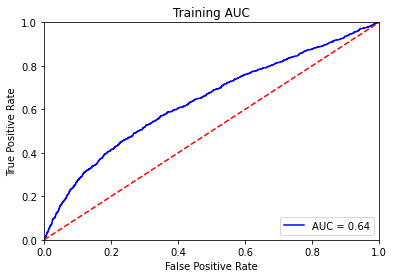

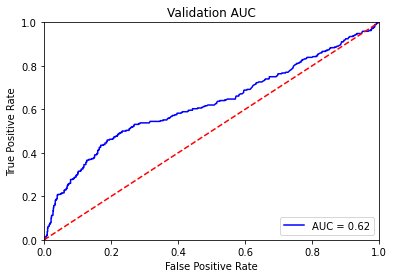

In [77]:
plot_roc(train_targs, train_probs)
plt.title("Training AUC")
plot_roc(val_targs, val_probs)
plt.title("Validation AUC")

In [53]:
from torchviz import make_dot

ModuleNotFoundError: No module named 'torchviz'

In [133]:
# Initialize network
net = Net(num_classes=num_classes).to(device)
x = torch.randn(1,54,420)
#y = model_see(x)

vis_graph = make_dot(net(x).mean(), params=dict(net.named_parameters()))
# vis_graph.view()

KeyboardInterrupt: ignored

In [136]:
from graphviz import Source; 
model_arch = make_dot(net(x).mean(), params=dict(net.named_parameters())); 
Source(model_arch).render('arch.png')

KeyboardInterrupt: ignored

In [137]:
from graphviz import Source
Source.from_file('/content/Digraph.gv')

KeyboardInterrupt: ignored

In [ ]:
make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz",

In [132]:
print(vis_graph)
#vis_graph.format = 'png'
#vis_graph.render("arch.png")

digraph {
	graph [size="561.15,561.15"]
	node [align=left fontname=monospace fontsize=10 height=0.2 ranksep=0.1 shape=box style=filled]
	139720133539712 [label="
 ()" fillcolor=darkolivegreen1]
	139720136060560 [label=MeanBackward0]
	139720136470736 -> 139720136060560
	139720136470736 [label=SigmoidBackward]
	139720133071376 -> 139720136470736
	139720133071376 [label=AddmmBackward]
	139720210747152 -> 139720133071376
	139720136651232 [label="fc1.bias
 (1)" fillcolor=lightblue]
	139720136651232 -> 139720210747152
	139720210747152 [label=AccumulateGrad]
	139720210746448 -> 139720133071376
	139720210746448 [label=ViewBackward]
	139720136239440 -> 139720210746448
	139720136239440 [label=TransposeBackward0]
	139720133349968 -> 139720136239440
	139720133349968 [label=StackBackward]
	139720135792272 -> 139720133349968
	139720135792272 [label=MulBackward0]
	139720131488784 -> 139720135792272
	139720131488784 [label=SigmoidBackward]
	139720131488976 -> 139720131488784
	139720131488976 [label=Un

In [ ]:
#model save below
# Write model to disk for use in predict.py
print("Saving model to src/model.pt")
torch.save(net.state_dict(), "/content/tcr-pmhc/src/model.pt")

Saving model to src/model.pt


In [ ]:
#### download the zip
!zip -r /content/models.zip /content/models_save

  adding: content/models_save/ (stored 0%)
  adding: content/models_save/model-epoch-29.pt (deflated 9%)
  adding: content/models_save/model-epoch-14.pt (deflated 9%)
  adding: content/models_save/model-epoch-10.pt (deflated 9%)
  adding: content/models_save/model-epoch-18.pt (deflated 9%)
  adding: content/models_save/model-epoch-2.pt (deflated 10%)
  adding: content/models_save/model-epoch-30.pt (deflated 9%)
  adding: content/models_save/model-epoch-35.pt (deflated 9%)
  adding: content/models_save/model-epoch-5.pt (deflated 9%)
  adding: content/models_save/model-epoch-23.pt (deflated 9%)
  adding: content/models_save/model-epoch-13.pt (deflated 9%)
  adding: content/models_save/model-epoch-31.pt (deflated 9%)
  adding: content/models_save/model-epoch-0.pt (deflated 9%)
  adding: content/models_save/model-epoch-28.pt (deflated 9%)
  adding: content/models_save/model-epoch-20.pt (deflated 9%)
  adding: content/models_save/model-epoch-17.pt (deflated 9%)
  adding: content/models_save

# Helpful scripts

# Show dataset as copied dataframes with named features
The dataset is a 3D numpy array, of dimensions n_complexes x features x positions. This makes viewing the features for individual complexes or samples challenging. Below is a function which copies the entire dataset, and converts it into a list of DataFrames with named indices and columns, in order to make understanding the data easier.

NB: This list of dataframes are only copies, and will not be passable into the neural network architecture.

In [ ]:
pd.read_csv("/content/tcr-pmhc/data/example.csv")

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y,per_res_fa_atr,per_res_fa_rep,per_res_fa_sol,per_res_fa_elec,per_res_fa_dun,per_res_p_aa_pp,per_res_score,foldx_MP,foldx_MA,foldx_MB,foldx_PA,foldx_PB,foldx_AB,global_complex_total_score,global_complex_fa_atr,global_complex_fa_dun,global_complex_fa_elec,global_complex_fa_rep,global_complex_fa_sol,global_complex_p_aa_pp,global_tcr_total_score,global_tcr_fa_atr,global_tcr_fa_dun,global_tcr_fa_elec,global_tcr_fa_rep,global_tcr_fa_sol,global_tcr_p_aa_pp,global_pmhc_total_score,global_pmhc_fa_atr,global_pmhc_fa_dun,global_pmhc_fa_elec,global_pmhc_fa_rep,global_pmhc_fa_sol,global_pmhc_p_aa_pp
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.893,0.119,2.162,-0.315,0.000,0.000,0.560,-5.72761,-0.922174,-0.922063,-0.00758,0.0,-1.31529,-1144.062,526.035,-727.694,4.939,1458.171,-90.02,2.385,-593.753,285.323,-350.705,2.964,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-2.941,0.701,2.150,-1.024,0.133,-0.357,-2.177,-5.72761,-0.922174,-0.922063,-0.00758,0.0,-1.31529,-1144.062,526.035,-727.694,4.939,1458.171,-90.02,2.385,-593.753,285.323,-350.705,2.964,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.574,0.943,5.372,-3.233,1.531,-0.258,-4.839,-5.72761,-0.922174,-0.922063,-0.00758,0.0,-1.31529,-1144.062,526.035,-727.694,4.939,1458.171,-90.02,2.385,-593.753,285.323,-350.705,2.964,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-5.121,0.398,4.949,-3.739,0.560,0.108,-3.345,-5.72761,-0.922174,-0.922063,-0.00758,0.0,-1.31529,-1144.062,526.035,-727.694,4.939,1458.171,-90.02,2.385,-593.753,285.323,-350.705,2.964,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.474,1.257,3.211,-1.961,1.772,0.234,-2.829,-5.72761,-0.922174,-0.922063,-0.00758,0.0,-1.31529,-1144.062,526.035,-727.694,4.939,1458.171,-90.02,2.385,-593.753,285.323,-350.705,2.964,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000


In [ ]:
def copy_as_dataframes(dataset_X):
    """
    Returns list of DataFrames with named features from dataset_X,
    using example CSV file
    """
    df_raw = pd.read_csv("/content/tcr-pmhc/data/example.csv")
    return [pd.DataFrame(arr, columns = df_raw.columns) for arr in dataset_X]

named_dataframes = copy_as_dataframes(X_train)
print("Showing first complex as dataframe. Columns are positions and indices are calculated features")
named_dataframes[0]

Showing first complex as dataframe. Columns are positions and indices are calculated features


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y,per_res_fa_atr,per_res_fa_rep,per_res_fa_sol,per_res_fa_elec,per_res_fa_dun,per_res_p_aa_pp,per_res_score,foldx_MP,foldx_MA,foldx_MB,foldx_PA,foldx_PB,foldx_AB,global_complex_total_score,global_complex_fa_atr,global_complex_fa_dun,global_complex_fa_elec,global_complex_fa_rep,global_complex_fa_sol,global_complex_p_aa_pp,global_tcr_total_score,global_tcr_fa_atr,global_tcr_fa_dun,global_tcr_fa_elec,global_tcr_fa_rep,global_tcr_fa_sol,global_tcr_p_aa_pp,global_pmhc_total_score,global_pmhc_fa_atr,global_pmhc_fa_dun,global_pmhc_fa_elec,global_pmhc_fa_rep,global_pmhc_fa_sol,global_pmhc_p_aa_pp
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.782,0.138,2.034,-0.177,0.000,0.000,0.845,-4.7732,-0.130164,-1.04623,0.0,-0.491463,-2.35094,-1196.707,486.534,-718.823,4.628,1396.761,-83.856,2.65,-633.309,250.617,-356.006,2.473,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-2.758,0.143,2.069,-0.791,0.088,-0.405,-2.431,-4.7732,-0.130164,-1.04623,0.0,-0.491463,-2.35094,-1196.707,486.534,-718.823,4.628,1396.761,-83.856,2.65,-633.309,250.617,-356.006,2.473,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.250,0.533,5.178,-3.381,1.675,-0.279,-5.730,-4.7732,-0.130164,-1.04623,0.0,-0.491463,-2.35094,-1196.707,486.534,-718.823,4.628,1396.761,-83.856,2.65,-633.309,250.617,-356.006,2.473,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-4.617,0.141,4.256,-2.504,0.133,-0.516,-4.379,-4.7732,-0.130164,-1.04623,0.0,-0.491463,-2.35094,-1196.707,486.534,-718.823,4.628,1396.761,-83.856,2.65,-633.309,250.617,-356.006,2.473,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.749,1.539,3.135,-2.211,1.483,0.093,-4.812,-4.7732,-0.130164,-1.04623,0.0,-0.491463,-2.35094,-1196.707,486.534,-718.823,4.628,1396.761,-83.856,2.65,-633.309,250.617,-356.006,2.473,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000000,0.00000,0.0,0.000000,0.00000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000000,0.00000,0.0,0.000000,0.00000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000000,0.00000,0.0,0.000000,0.00000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000000,0.00000,0.0,0.000000,0.00000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000


# View complex MHC, peptide and TCR alpha/beta sequences
You may want to view the one-hot encoded sequences as sequences in single-letter amino-acid format. The below function will return the TCR, peptide and MHC sequences for the dataset as 3 lists.

In [ ]:
def oneHot(residue):
    """
    Converts string sequence to one-hot encoding
    Example usage:
    seq = "GSHSMRY"
    oneHot(seq)
    """
    
    mapping = dict(zip("ACDEFGHIKLMNPQRSTVWY", range(20)))
    if residue in "ACDEFGHIKLMNPQRSTVWY":
        return np.eye(20)[mapping[residue]]
    else:
        return np.zeros(20)
def reverseOneHot(encoding):
    """
    Converts one-hot encoded array back to string sequence
    """
    mapping = dict(zip(range(20),"ACDEFGHIKLMNPQRSTVWY"))
    seq=''
    for i in range(len(encoding)):
        if np.max(encoding[i])>0:
            seq+=mapping[np.argmax(encoding[i])]
    return seq

def extract_sequences(dataset_X):
    """
    Return DataFrame with MHC, peptide and TCR a/b sequences from
    one-hot encoded complex sequences in dataset X
    """
    mhc_sequences = [reverseOneHot(arr[0:179,0:20]) for arr in dataset_X]
    pep_sequences = [reverseOneHot(arr[179:190,0:20]) for arr in dataset_X]
    tcr_sequences = [reverseOneHot(arr[192:,0:20]) for arr in dataset_X]
    df_sequences = pd.DataFrame({"MHC":mhc_sequences, "peptide":pep_sequences,
                                 "tcr":tcr_sequences})
    return df_sequences

In [ ]:
complex_sequences = extract_sequences(X_val)
print("Showing MHC, peptide and TCR alpha/beta sequences for each complex")
complex_sequences

Showing MHC, peptide and TCR alpha/beta sequences for each complex


,MHC,peptide,tcr
0,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GLCTLVAML,VEQHPSTLSVQEGDSAVIKCTYSDSASNYFPWYKQELGKGPQLIID...
1,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,TQTQPGMFVQEKEAVTLDCTYDTSDPSYGLFWYKQPSSGEMIFLIY...
2,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GLCTLVAML,QVEQSPQSLIILEGKNCTLQCNYTVSPFSNLRWYKQDTGRGPVSLT...
3,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,QVEQSPPDLILQEGANSTLRCNFSDSVNNLQWFHQNPWGQLINLFY...
4,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,QPSTVASSEGAVVEIFCNHSVSNAYNFFWYLHFPGCAPRLLVKGSK...
...,...,...,...
1527,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,NLVPMVATV,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
1528,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,NLVPMVATV,QSVTQLGSHVSVSEGALVLLRCNYSSSVPPYLFWYVQYPNQGLQLL...
1529,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GLCTLVAML,VQEGEDFTTYCNSSTTLSNIQWYKQRPGGHPVFLIQLVKSGEVKKK...
1530,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GLCTLVAML,VQEGEDFTTYCNSSTTLSNIQWYKQRPGGHPVFLIQLVKSGEVKKK...


In [ ]:
### backup of convnet
# ################################ THIS NETWORK WORKS GOOD- DO NOT EDIT
# ###############################
# ###    Define network       ###
# ###############################

# print("Initializing network")

# # Hyperparameters
# input_size = 420
# num_classes = 1
# learning_rate = 0.001 #0.0001

# class Net(nn.Module):
#     def __init__(self,  num_classes):
#         super(Net, self).__init__()
#         self.bn0 = nn.BatchNorm1d(54) ### edited after 4:30 PM       
#         self.conv1 = nn.Conv1d(in_channels=54, out_channels=100, kernel_size=3, stride=2, padding=1)
#         torch.nn.init.kaiming_uniform_(self.conv1.weight)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.conv1_bn = nn.BatchNorm1d(100)
        
#         self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
#         torch.nn.init.kaiming_uniform_(self.conv2.weight)
#         self.conv2_bn = nn.BatchNorm1d(100)
        
#         self.fc1 = nn.Linear(2600, num_classes)
#         torch.nn.init.xavier_uniform_(self.fc1.weight)
        
#     def forward(self, x):
#         x = self.bn0(x)      ### edited after 4:30 PM   
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.conv1_bn(x)
        
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.conv2_bn(x)
        
#         x = x.view(x.size(0), -1)
#         #x = self.fc1(x)
#         x = torch.sigmoid(self.fc1(x))

        
#         return x
    
# # Initialize network
# net = Net(num_classes=num_classes).to(device)


# ## unbalanced loss
# #unbal_weight = torch.tensor([1,0.333]).to(device)

# # Loss and optimizer
# #criterion = nn.BCELoss()
# #criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate,
#                        weight_decay=0.003,
#                        amsgrad=True,
#                        ) 



# #optim.SGD(net.parameters(), lr=learning_rate)